# Для запуска в Google Colab

Раскомментируйте команды ниже для запуска в Colab. Код был протестирован с Python 3.8 и PyTorch 1.8 CUDA 11.

**После установки зависимостей необходим перезапуск окружения** 

In [1]:
# !apt install -y  git-lfs
# !git lfs version

In [2]:
# %cd /content

In [3]:
# !if [ ! -d ./made-adv-ml-hw2 ]; then git clone -b master --depth 1 --single-branch https://github.com/KernelA/made-adv-ml-hw2.git; fi

In [4]:
# %cd /content/made-adv-ml-hw2

In [5]:
# !git lfs pull

In [6]:
# !pip install -r ./requirements.txt

In [7]:
# !if [ -f ./.dvc/tmp/rwlock ]; then rm ./.dvc/tmp/rwlock; fi

In [8]:
# !dvc repro train_test_split

In [9]:
import pathlib
import pickle
import shutil
import random

import numpy as np
import pandas as pd
from sklearn import preprocessing, linear_model
from scipy import sparse
from tqdm import tqdm
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

plt.style.use("bmh")
mpl.rcParams["figure.figsize"] = (8, 8)

In [10]:
np.random.seed(12)
random.seed(22)
torch.manual_seed(0)
torch.set_default_dtype(torch.float32)

In [11]:
%load_ext autoreload

%autoreload 2

In [12]:
from rating_model import TeamResults
from rating_model import PICKLE_PROTOCOL
from rating_model import EMRatingModel, get_player_skills, estimate_rank
from utils import load_pickle, dump_pickle, optimize_dataframe_numeric_dtypes

# 1 Предобработка данных

Основная логика предоработки данных содержится в .py файлах проекта.

In [13]:
tours_datapath = pathlib.Path("data", "pickle_data", "tournaments-dt.pickle")

In [14]:
tours = pd.read_pickle(tours_datapath)

In [15]:
players_datapath = pathlib.Path("data", "pickle_data", "players-dt.pickle")

In [16]:
players_info = pd.read_pickle(players_datapath)

In [17]:
team_res_datapath = pathlib.Path(
    "data", "team_res", "train_team_results.pickle")

In [18]:
team_res = load_pickle(team_res_datapath)

In [19]:
total_unknown_team_players = 0
total_unknown_answers = 0
for tour_id in team_res.tours:
    for team_id in team_res[tour_id]:
        team = team_res[tour_id][team_id]
        if not team.members:
            total_unknown_team_players += 1
        if not team.mask:
            total_unknown_answers += 1

In [20]:
print("Количество команд без состава команды: ", total_unknown_team_players,
      "Количество команд с неизвестными повопроснами результатами: ", total_unknown_answers, sep="\n")

Количество команд без состава команды: 
69
Количество команд с неизвестными повопроснами результатами: 
173


In [21]:
tours.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1105 entries, 4628 to 6485
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   name          1105 non-null   object             
 1   dateStart     1105 non-null   datetime64[ns, UTC]
 2   dateEnd       1105 non-null   datetime64[ns, UTC]
 3   type          1105 non-null   object             
 4   season        1015 non-null   object             
 5   orgcommittee  1105 non-null   object             
 6   synchData     669 non-null    object             
 7   questionQty   1105 non-null   object             
dtypes: datetime64[ns, UTC](2), object(6)
memory usage: 77.7+ KB


In [22]:
players_dump = pathlib.Path("dump", "players.pickle")
players_dump.parent.mkdir(exist_ok=True, parents=True)

In [23]:
force_get_players = False

In [24]:
players = None

In [25]:
if not players_dump.exists() or force_get_players:
    players = team_res.to_player_dataframe(filter_by_mask=True)
    optimize_dataframe_numeric_dtypes(players)
    dump_pickle(players_dump, players)
else:
    players = load_pickle(players_dump)

In [26]:
assert players.index.is_monotonic_increasing

In [27]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17823516 entries, 0 to 17823515
Data columns (total 5 columns):
 #   Column           Dtype
---  ------           -----
 0   tour_id          int16
 1   team_id          int32
 2   player_id        int32
 3   answer_id        int32
 4   is_right_answer  bool 
dtypes: bool(1), int16(1), int32(3)
memory usage: 255.0 MB


In [28]:
players.head()

,tour_id,team_id,player_id,answer_id,is_right_answer
0,4772,45556,6212,0,True
1,4772,45556,6212,1,True
2,4772,45556,6212,2,True
3,4772,45556,6212,3,True
4,4772,45556,6212,4,True


## 2 Построение логистической регрессии для ранжирования игроков

Пусть параметры модели образуют составляют вектор $w = \left(s_1,s_2,\ldots,s_P, c_1, c_2, \ldots, c_A, b \right)^T,$ где $P-$ общее число игроков, $A-$ общее число вопросов. Таким образом значения параметров будут обозначать "силы игроков" $s_i, i=1,\ldots,P$ и сложнности вопросов $c_j, j=1,\ldots,A$, $b$- глоабальный коэффициент смещения/

Распредление ответов по всем игрокам:

<AxesSubplot:>

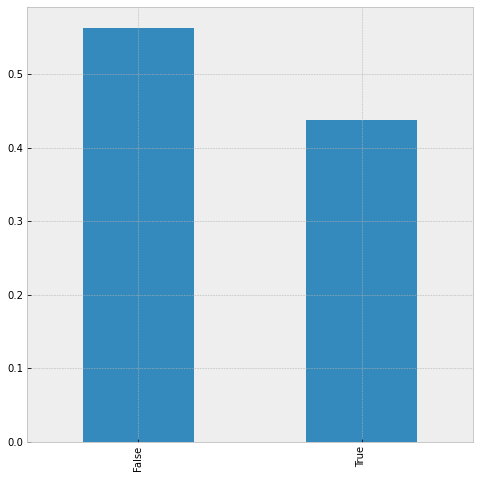

In [29]:
players["is_right_answer"].value_counts(normalize=True).plot.bar()

In [30]:
feature_dtype = np.float64

In [31]:
def get_features_target(players: pd.DataFrame, feature_dtype):
    skils_encoder = preprocessing.OneHotEncoder(dtype=feature_dtype)
    skils_features_one_hot = skils_encoder.fit_transform(players["player_id"].to_numpy().reshape(-1, 1))
    questione_complex_encoder = preprocessing.OneHotEncoder(dtype=feature_dtype)
    question_complices_one_hot = questione_complex_encoder.fit_transform(players["answer_id"].to_numpy().reshape(-1, 1))
    features = sparse.hstack(
    (skils_features_one_hot, question_complices_one_hot), format="csr")
    return skils_encoder, questione_complex_encoder, features, players["is_right_answer"].astype(np.int8).to_numpy()

In [32]:
skils_encoder, questione_complex_encoder, features, target = get_features_target(players, feature_dtype)

In [33]:
assert sparse.isspmatrix_csr(features)

In [34]:
features

<17823516x91209 sparse matrix of type '<class 'numpy.float64'>'
	with 35647032 stored elements in Compressed Sparse Row format>

In [35]:
dump_model_filepath = pathlib.Path("model", "log-reg")

In [36]:
dump_model_filepath.mkdir(parents=True, exist_ok=True)

In [37]:
force_train = False

In [38]:
model_dump = dump_model_filepath / "log-reg.pickle"

In [39]:
regression = None

In [40]:
if not force_train and model_dump.exists():
    regression = load_pickle(model_dump)

In [41]:
if regression is None:
    regression = linear_model.LogisticRegression(
        penalty="l1", C=1000, solver="liblinear", verbose=2, max_iter=25, fit_intercept=True)
    regression.fit(features, target)
    dump_pickle(model_dump, regression)

### Рейтинг игроков

Сравним позиции игроков на основе рейтингов с реальными позициями на момент [26 декабря 2019 (выгрузка содержит только первые 1000 записей)](https://rating.chgk.info/players.php?release=1429&surname=&name=&patronymic=&idplayer=28751&town=&search=%D0%98%D1%81%D0%BA%D0%B0%D1%82%D1%8C)

In [42]:
path_to_real_ratings = pathlib.Path(
    "data", "raw_data", "players-release-2019-12-26.csv")

In [43]:
top_n = 10

In [44]:
real_data = pd.read_csv(path_to_real_ratings, usecols=[
                        "id", "Место"], index_col="id", nrows=top_n)

In [45]:
player_ratings = get_player_skills(skils_encoder, regression.coef_[0])
player_ratings.sort_values("skill", inplace=True, ascending=False)

In [46]:
player_ratings[:top_n].join(real_data)

,skill,Место
27403,3.107026,5.0
4270,2.970318,6.0
28751,2.917373,2.0
27822,2.829079,3.0
30270,2.757737,4.0
40411,2.755631,NaN
30152,2.744717,1.0
38175,2.685589,NaN
20691,2.647100,NaN
199963,2.604934,NaN


В результате часть игроков, попавшие в топ из реального рейтинга совпали с результатом ранжирования после обучения логистической регрессии, но их позиции точно не совпали. Существуют игроки, которых не было в реальном рейтинге топ-1000. 

## 3 Оценка результатов

Для сравнение команд воспользуемся простым правилом. Для каждой команды в турнире её "сила" будет определяться как среднее значение "силы  игроков". После команды ранжируются на основании значений их "силы". 

In [47]:
test_team_res_datapath = pathlib.Path(
    "data", "team_res", "test_team_results.pickle")

In [48]:
team_res_test = load_pickle(test_team_res_datapath)

In [49]:
test_team_ratings = team_res_test.to_team_rating_by_tour()

In [50]:
test_team_ratings.head()

,tour_id,members,team_id,tour_rating
0,4957,"(30152, 30270, 27822, 28751, 27403, 4270)",49804,1.0
1,4957,"(34936, 40877, 25177, 113703, 33792, 107161)",4109,2.0
2,4957,"(33620, 21346, 13857, 46339, 37836, 19632)",3875,3.0
3,4957,"(32901, 28689, 19541, 13689, 9801, 18194)",77418,4.0
4,4957,"(6482, 34846, 36120, 32458, 25882, 30475)",2,5.5


### Коэффициент ранговой корреляции Кендалла и Спирмена 

In [51]:
baseline = estimate_rank(test_team_ratings, player_ratings)

In [52]:
print(*baseline.items(), sep="\n")

('Kendall', 0.60875620064822)
('Spearman', 0.7716014463677552)


In [53]:
del player_ratings

## 4 EM алгоритм

Рассмртрим ответы команды на вопросы. Если команда $t$ ответила на вопрос $q$, то это означает, что хотя бы один игрок ответил на вопрос. Если команда не ответила на вопрос, то это означает, что ни один игрок также не оветил на вопрос.

Таким образом введём скрытые переменные: $h_{i,q}$- игорок под номером $i$ ответил на вопрос $q$. Они связаны с $x_{t,q}$ следующим соотношением:
$$
x_{t,q} = 
\begin{cases}
0, \text{ то } h_{i,q} = 0 \text{ для всех игроков в команде } t,\\
1, \text{ то } \exists i \in t : h_{i,q}=1 \text{ т. е. хотя бы один игрока в команде } t \text{ ответил правильно}. 
\end{cases}
$$

Пусть распределение $h_{i,q}$ при условии "силы" игрока и сложности вопроса моделируется с помощью сигмоиды $p\left(h_{i,q} \vert s_i, c_q\right) \sim \sigma\left(b + s_i + c_q\right), s_i-$ сила игрока $i$, $c_q-$ сложность вопроса $q$, $b \in \mathbb{R}-$ глобальное смещение, $\sigma\left(\cdot\right)-$ сигмоида.

Рассмотрим итерацию EM-алгоритма для шага $m \geq 0$.

## E-шаг

$$
\mathrm{M} \left[ h^{(m+1)}_{i,q} \right] = 
\begin{cases}
0, \forall i \in t : x_{t,q} = 0,\\
p\left( h^{(m)}_{i,q} = 1 \vert \exists j \in t : h^{(m)}_{j,q} = 1\right) =
\dfrac{\sigma \left(b^{(m)} + s^{(m)}_i + c^{(m)}_q\right)}{1-\prod\limits_{k \in t} \left(1 - \sigma\left(b^{(m)} + s^{(m)}_k + c^{(m)}_q\right)\right)}, \text{ если } x_{t,q} = 1.
\end{cases}
$$

## М-шаг

Происходит обучение логистичексой регрессии при известных $\mathrm{M} \left[ h^{(m+1)}_{i,q} \right]$ и уточнение параметров:
$$
\mathrm{M} \left[ h^{(m+1)}_{i,q} \right] \sim \sigma\left(b^{(m+1)} + s^{(m+1)}_i + c^{(m+1)}_q\right)
$$

В качестве начального приближения параметров возьмём значения, полученные при обучении логистической регрессии.

In [54]:
def train_em(features, target, players, skils_encoder, test_team_ratings, baseline, init_weights, init_bias):
    coo_features = features.tocoo(copy=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    log_dir = pathlib.Path("em_train", "logs")
    if log_dir.exists():
        shutil.rmtree(log_dir)
    log_dir.mkdir(exist_ok=True, parents=True)

    checkpoint_dir = pathlib.Path("em_train", "checkpoints")
    if checkpoint_dir.exists():
        shutil.rmtree(checkpoint_dir)
    checkpoint_dir.mkdir(exist_ok=True, parents=True)

    em_model = EMRatingModel(em_num_iter=8, lr=1e-4,
                             log_reg_num_iter=5, device=device, log_dir=log_dir, checkpoint_dir=str(checkpoint_dir))
    
    metrics_history = em_model.fit(coo_features, target, players, skils_encoder,
                               test_team_ratings, baseline, init_weights, init_bias)
    return metrics_history, em_model.best_checkpoint_file()

In [55]:
metrics_history, path_to_checkpoint = train_em(features, target, players, skils_encoder, test_team_ratings, baseline, regression.coef_, regression.intercept_)

2021-04-08 01:23:47,417 INFO em_algo __init__ Will train logistic regression on cuda
2021-04-08 01:23:57,834 INFO em_algo _build_player_team_round_indices Building mask for zeroing hidden variables
2021-04-08 01:23:57,857 INFO em_algo _build_player_team_round_indices Use 100000 as base value for grouping


Train logistic regression: 100%|███████████████| 5/5 [00:04<00:00,  1.18it/s, Binary cross entropy=0.464, MAE=0.000208]


2021-04-08 01:24:57,332 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:24:57,333 INFO em_algo _validate Kendall +0.000010
2021-04-08 01:24:57,333 INFO em_algo _validate Spearman +0.000005
2021-04-08 01:24:57,334 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-08 01:24:57,650 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6087660696990155, 'Spearman': 0.7716068197988547}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.33it/s, Binary cross entropy=0.464, MAE=0.000208]


2021-04-08 01:25:10,780 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:25:10,781 INFO em_algo _validate Kendall +0.000007
2021-04-08 01:25:10,782 INFO em_algo _validate Spearman +0.000006
2021-04-08 01:25:10,783 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:25:10,783 INFO em_algo _validate Kendall -0.000003
2021-04-08 01:25:10,784 INFO em_algo _validate Spearman +0.000001
2021-04-08 01:25:10,786 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6087632013197116, 'Spearman': 0.7716075452336233}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.34it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-08 01:25:23,616 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:25:23,617 INFO em_algo _validate Kendall +0.000420
2021-04-08 01:25:23,618 INFO em_algo _validate Spearman +0.000560
2021-04-08 01:25:23,620 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-08 01:25:23,634 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:25:23,636 INFO em_algo _validate Kendall +0.000413
2021-04-08 01:25:23,638 INFO em_algo _validate Spearman +0.000554
2021-04-08 01:25:23,639 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091766398099967, 'Spearman': 0.7721611951658316}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.30it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-08 01:25:37,526 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:25:37,527 INFO em_algo _validate Kendall +0.000422
2021-04-08 01:25:37,528 INFO em_algo _validate Spearman +0.000563
2021-04-08 01:25:37,529 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-08 01:25:37,536 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:25:37,538 INFO em_algo _validate Kendall +0.000002
2021-04-08 01:25:37,539 INFO em_algo _validate Spearman +0.000003
2021-04-08 01:25:37,540 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091786380404252, 'Spearman': 0.7721644945218163}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.33it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-08 01:25:51,005 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:25:51,005 INFO em_algo _validate Kendall +0.000423
2021-04-08 01:25:51,006 INFO em_algo _validate Spearman +0.000565
2021-04-08 01:25:51,007 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-08 01:25:51,011 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:25:51,012 INFO em_algo _validate Kendall +0.000000
2021-04-08 01:25:51,013 INFO em_algo _validate Spearman +0.000002
2021-04-08 01:25:51,018 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091787711224768, 'Spearman': 0.772166480155201}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.31it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-08 01:26:04,518 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:26:04,519 INFO em_algo _validate Kendall +0.000420
2021-04-08 01:26:04,520 INFO em_algo _validate Spearman +0.000593
2021-04-08 01:26:04,521 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:26:04,522 INFO em_algo _validate Kendall -0.000002
2021-04-08 01:26:04,523 INFO em_algo _validate Spearman +0.000028
2021-04-08 01:26:04,525 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091765094100018, 'Spearman': 0.7721944570279101}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.30it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-08 01:26:17,258 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:26:17,259 INFO em_algo _validate Kendall +0.000421
2021-04-08 01:26:17,260 INFO em_algo _validate Spearman +0.000593
2021-04-08 01:26:17,262 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:26:17,264 INFO em_algo _validate Kendall +0.000001
2021-04-08 01:26:17,265 INFO em_algo _validate Spearman +0.000000
2021-04-08 01:26:17,267 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091770751029917, 'Spearman': 0.7721948046995829}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.32it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-08 01:26:29,969 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:26:29,970 INFO em_algo _validate Kendall +0.000424
2021-04-08 01:26:29,971 INFO em_algo _validate Spearman +0.000597
2021-04-08 01:26:29,971 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-08 01:26:29,975 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:26:29,977 INFO em_algo _validate Kendall +0.000003
2021-04-08 01:26:29,978 INFO em_algo _validate Spearman +0.000003
2021-04-08 01:26:29,980 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091798358697247, 'Spearman': 0.772198179855955}


M step: 100%|████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.68s/it]


In [56]:
def plot_target_metrics(metrics_history: dict):
    iterations = metrics_history["em_iter"]

    fig = plt.figure(figsize=(15, 7))
    axes = fig.subplots(1, len(metrics_history) - 1)
    for ax_num, metric_name in enumerate(filter(lambda x: x != "em_iter", metrics_history)):
        axes[ax_num].plot(
            iterations, metrics_history[metric_name], label=metric_name)
        axes[ax_num].hlines(baseline[metric_name], 0, max(
            iterations), colors="red", label="baseline")
        axes[ax_num].legend()
        axes[ax_num].set_xlabel("Итерация EM алгоритма")
        axes[ax_num].set_ylabel("Значение метрики")
        axes[ax_num].grid(True)

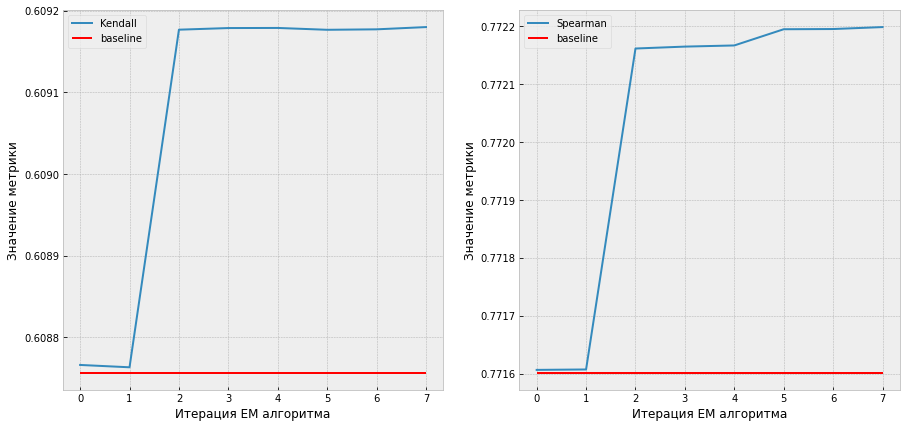

In [57]:
plot_target_metrics(metrics_history)

# 5 "Рейтинг-лист" турниров по сложности вопросов

In [229]:
state_key = "lin_layer.weight"

In [71]:
weights = torch.load(path_to_checkpoint, map_location="cpu")[state_key][0].numpy()

In [73]:
question_complex = pd.DataFrame({"question_complex": weights[len(skils_encoder.categories_[0]):]}, index=questione_complex_encoder.categories_[0])
question_complex.index.name = "answer_id"

In [74]:
question_complex.head()

,question_complex
answer_id,
0,2.016682
1,1.053138
2,-0.548386
3,-0.183907
4,1.979798


## Распредление сложностей вопросов

<AxesSubplot:ylabel='Density'>

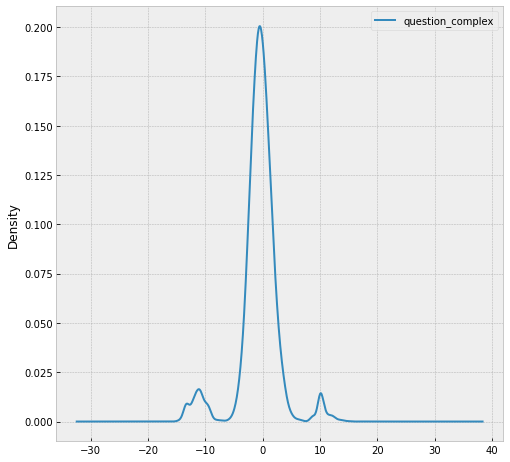

In [75]:
question_complex.plot.kde()

In [182]:
def question_to_complex(questions_ids, question_complexices, top_n: int = 10):
    complexices = question_complexices.loc[questions_ids, "question_complex"].to_numpy()
    return np.mean(complexices)

In [183]:
tours_with_questios = players[["tour_id", "answer_id"]].groupby("tour_id").apply(lambda x: x["answer_id"].to_list())
tours_with_questios = tours_with_questios.apply(lambda x: question_to_complex(x, question_complex, 5))

In [184]:
tours_with_questios.sort_values(ascending=True, inplace=True)

In [185]:
tours_with_questios.head()

tour_id
6149   -13.397834
5717    -4.772788
5930    -4.084815
5427    -3.570785
6101    -3.532730
dtype: float64

In [186]:
target.shape

(17823516,)

In [187]:
top_n = 10

In [188]:
tours.loc[tours_with_questios.iloc[:top_n].index, ["name", "type"]]

,name,type
tour_id,,
6149,Чемпионат Санкт-Петербурга. Первая лига,"{'id': 2, 'name': 'Обычный'}"
5717,Чемпионат Таджикистана,"{'id': 2, 'name': 'Обычный'}"
5930,Зеркало мемориала памяти Михаила Басса,"{'id': 3, 'name': 'Синхрон'}"
5427,День D,"{'id': 3, 'name': 'Синхрон'}"
6101,Воображаемый музей,"{'id': 3, 'name': 'Синхрон'}"
5532,Седьмая октава: Кубок Равноденствия. Лига Наци...,"{'id': 3, 'name': 'Синхрон'}"
5684,Синхрон высшей лиги Москвы,"{'id': 3, 'name': 'Синхрон'}"
5929,Мемориал памяти Михаила Басса,"{'id': 2, 'name': 'Обычный'}"
5928,Угрюмый Ёрш,"{'id': 3, 'name': 'Синхрон'}"


In [189]:
tours.loc[tours_with_questios.iloc[-top_n:].index, ["name", "type"]]

,name,type
tour_id,,
5705,Школьный Синхрон-lite. Выпуск 3.5,"{'id': 8, 'name': 'Асинхрон'}"
5457,Студенческий чемпионат Калининградской области,"{'id': 2, 'name': 'Обычный'}"
5012,Школьный Синхрон-lite. Выпуск 2.5,"{'id': 8, 'name': 'Асинхрон'}"
5827,Шестой киевский марафон. Асинхрон,"{'id': 8, 'name': 'Асинхрон'}"
5013,(а)Синхрон-lite. Лига старта. Эпизод V,"{'id': 8, 'name': 'Асинхрон'}"
6254,Школьная лига,"{'id': 5, 'name': 'Общий зачёт'}"
5955,Школьная лига. III тур.,"{'id': 8, 'name': 'Асинхрон'}"
5936,Школьная лига. I тур.,"{'id': 8, 'name': 'Асинхрон'}"
5438,Синхрон Лиги Разума,"{'id': 3, 'name': 'Синхрон'}"


Интуитивно в список турниров со сложными вопросами попали чемпионаты, а также турниры высшей лиги. В спсиок простых турниров попали более локальнеы туриниы. Некторые и них с упоминанием lite. Соответсвенно, ожидаемо, что чемионаты или турниры высшей лиги будут сложнее чем школьные лиги или студенческие чемпионаты.

Посмотрим на визуализацию ответов команд в этих турнирах.

In [226]:
def plot_tour(team_res, tours, tour_id):
    masks = []
    team_ids = []
    for team_id in team_res[tour_id]:
        if team_res[tour_id][team_id].mask:
            masks.append(team_res[tour_id][team_id].mask)
            team_ids.append(team_id)
    try:
        fig = plt.figure(figsize=(15, 20))
        ax = fig.add_subplot(111)
        ax.imshow(tuple(zip(*masks)), cmap="gray")
        ax.set_xticks([])
        ax.grid(False)
        ax.grid(True, axis="y", linewidth=2, color="red")
        ax.set_ylabel("Номер вопроса")
        ax.set_xlabel("Ответы команды")
        ax.set_title(tours.loc[tour_id, "name"])
    except TypeError:
        pass

## Самые сложные турниры

Виуализация ответов на вопросы. Белый цвет означает, что команда ответила на вопрос. Чёрный что не ответила. 

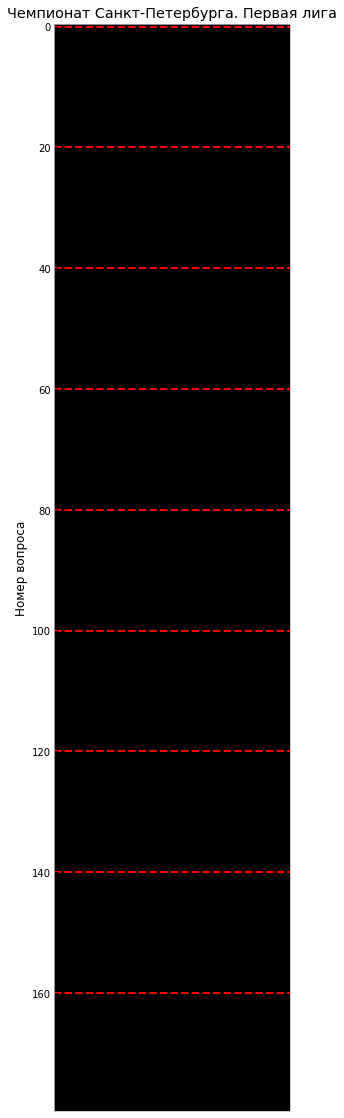

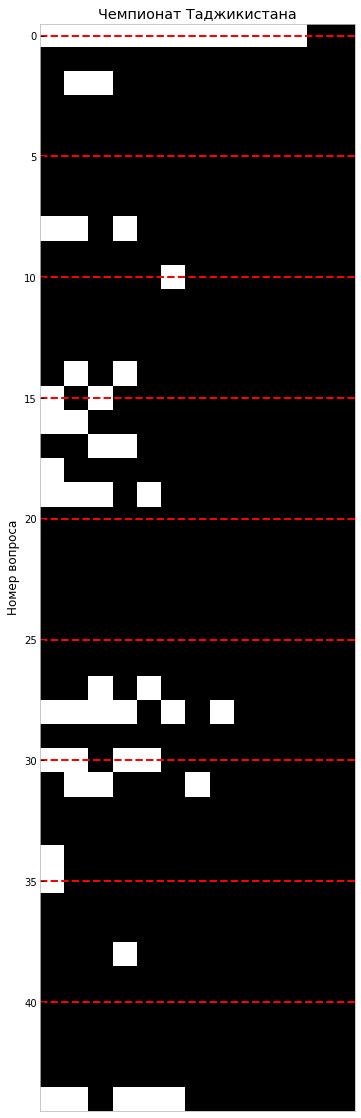

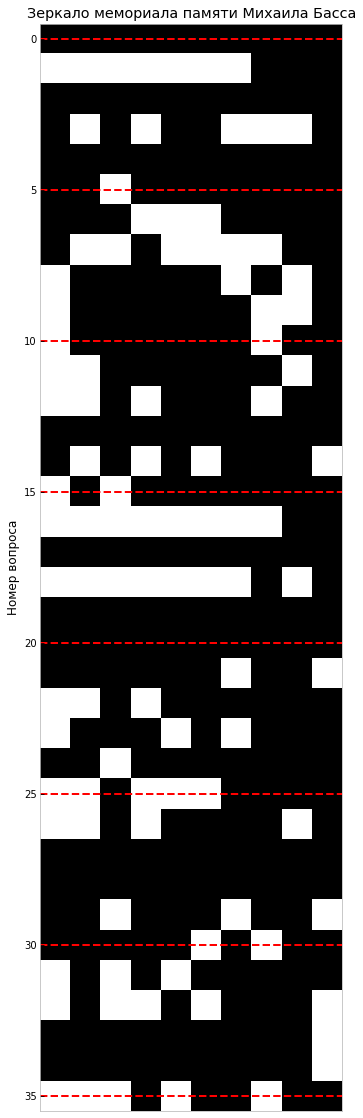

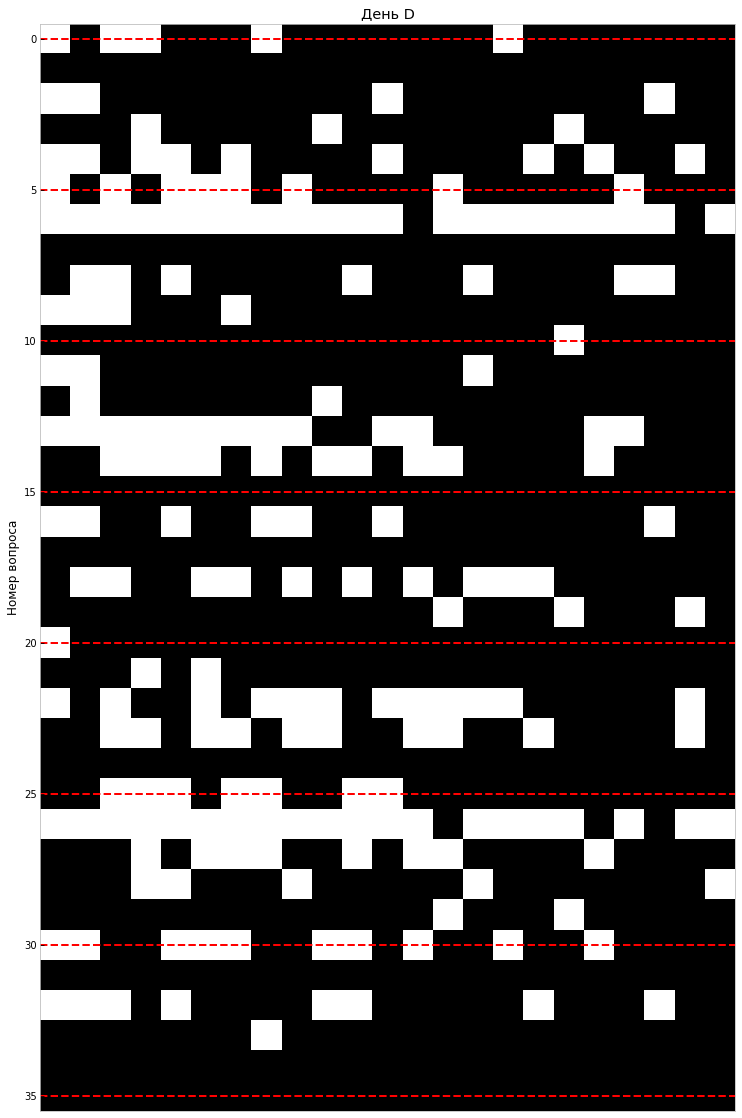

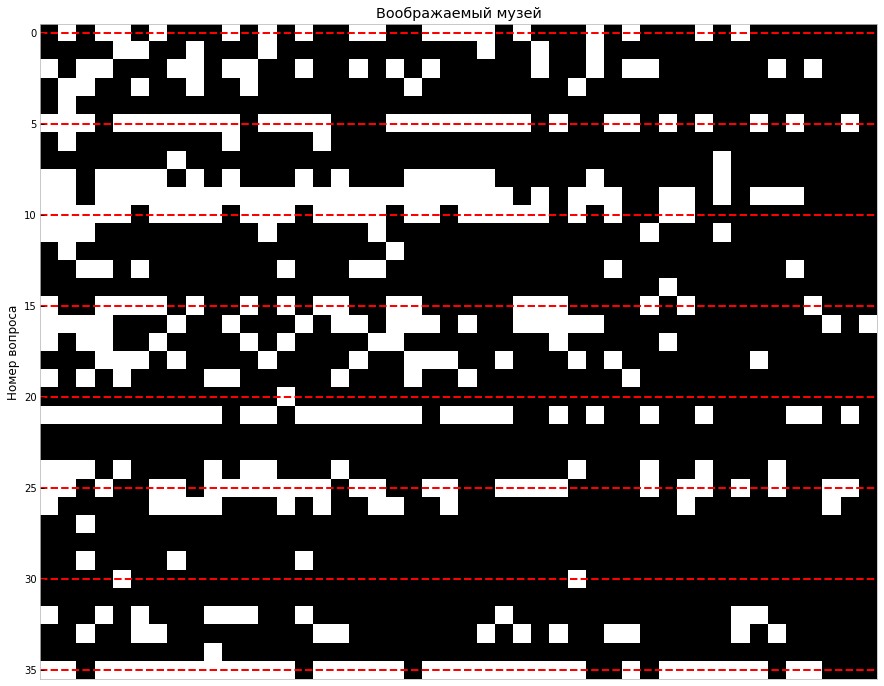

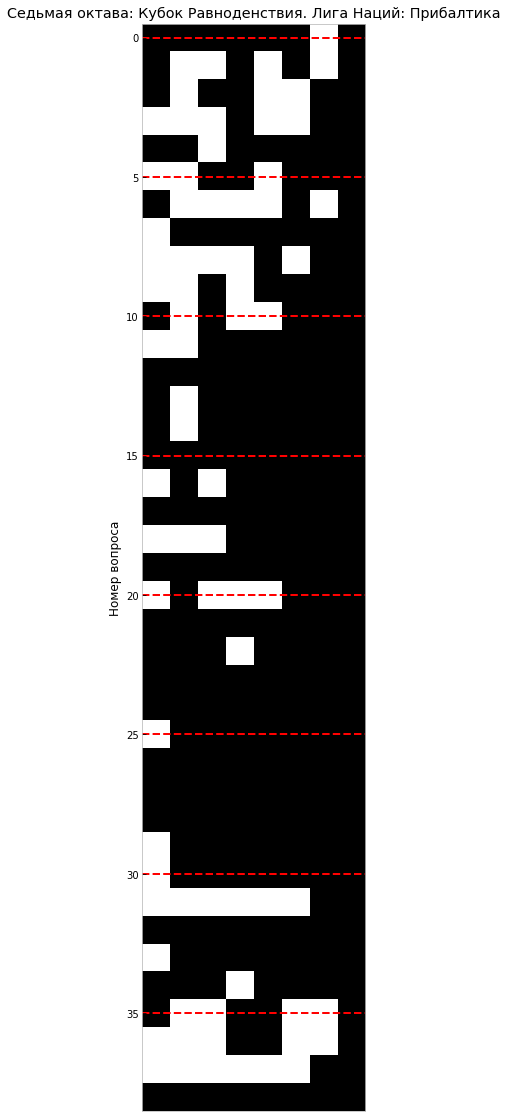

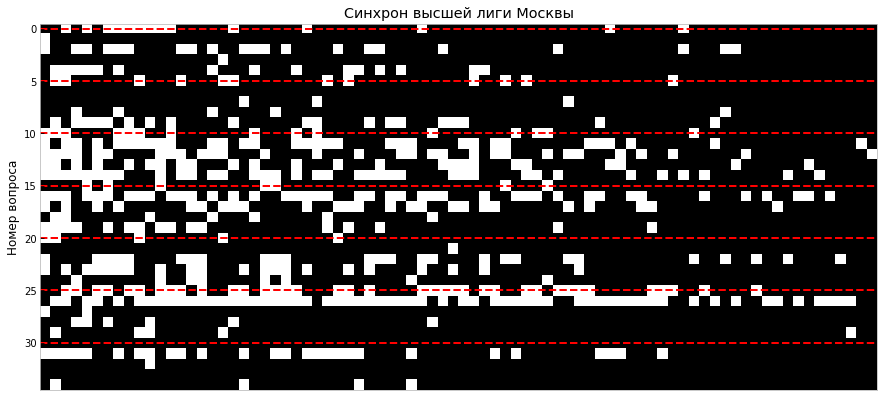

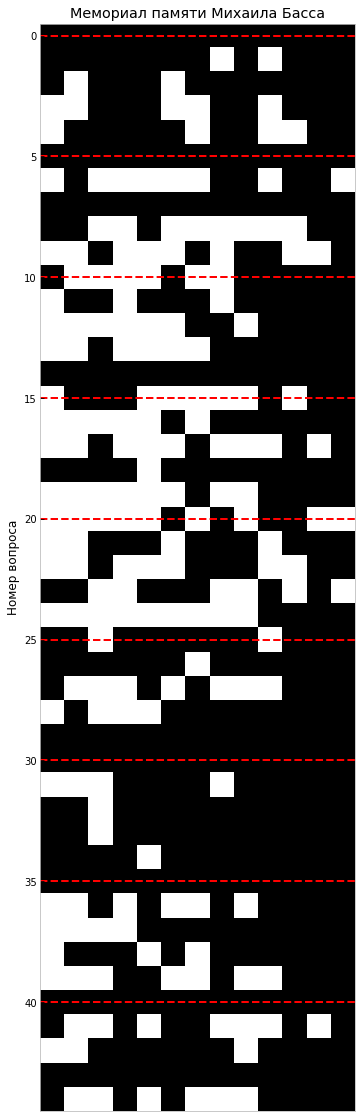

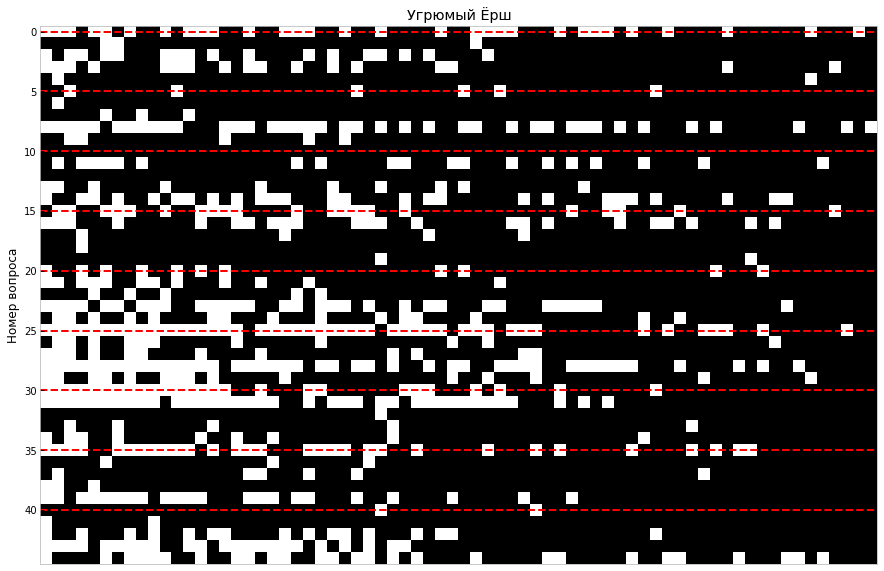

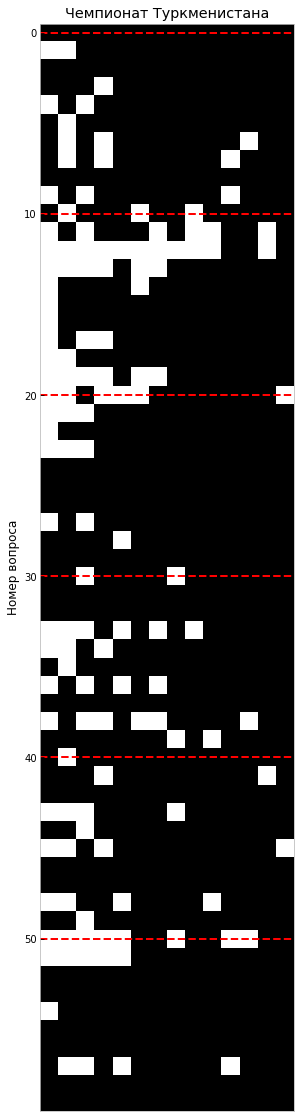

In [194]:
for tour_id in tours_with_questios.iloc[:10].index:
    plot_tour(team_res, tours, tour_id)

## Самые простые турниры

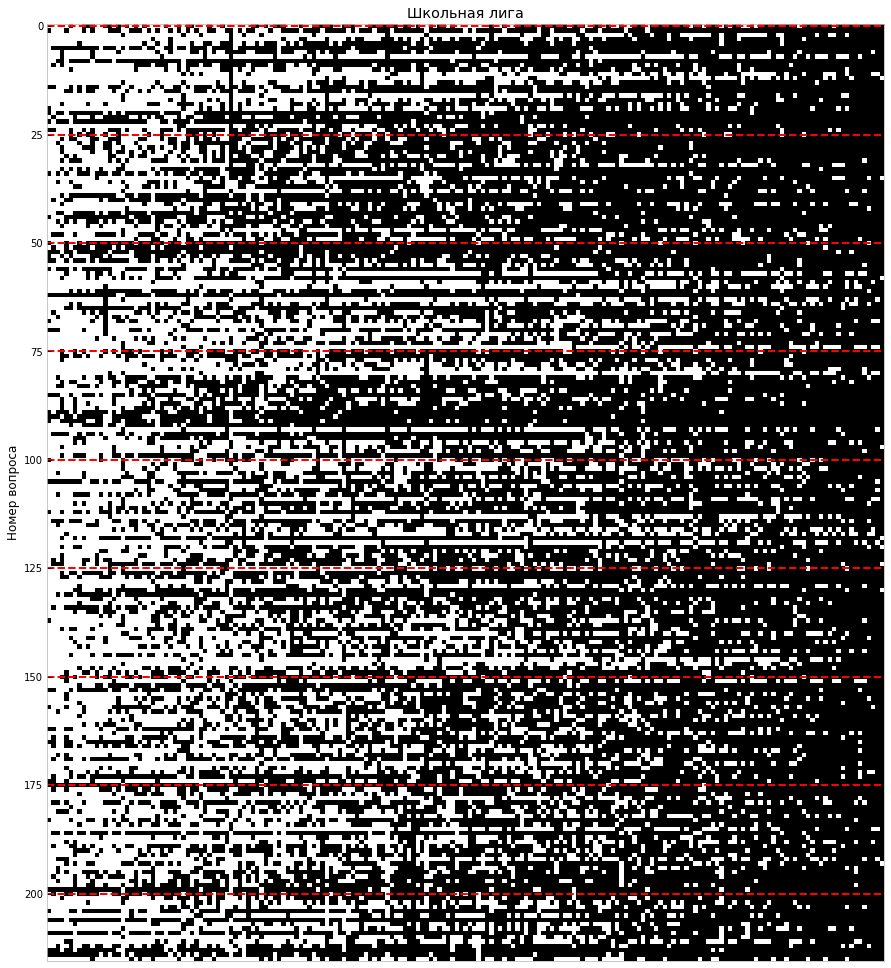

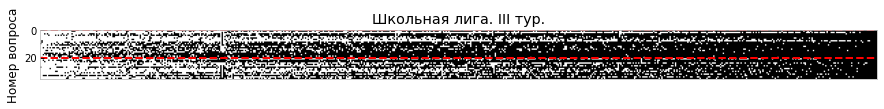

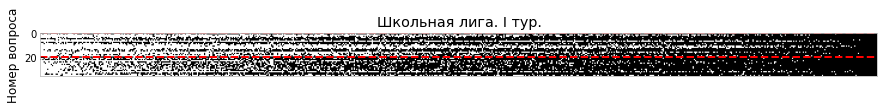

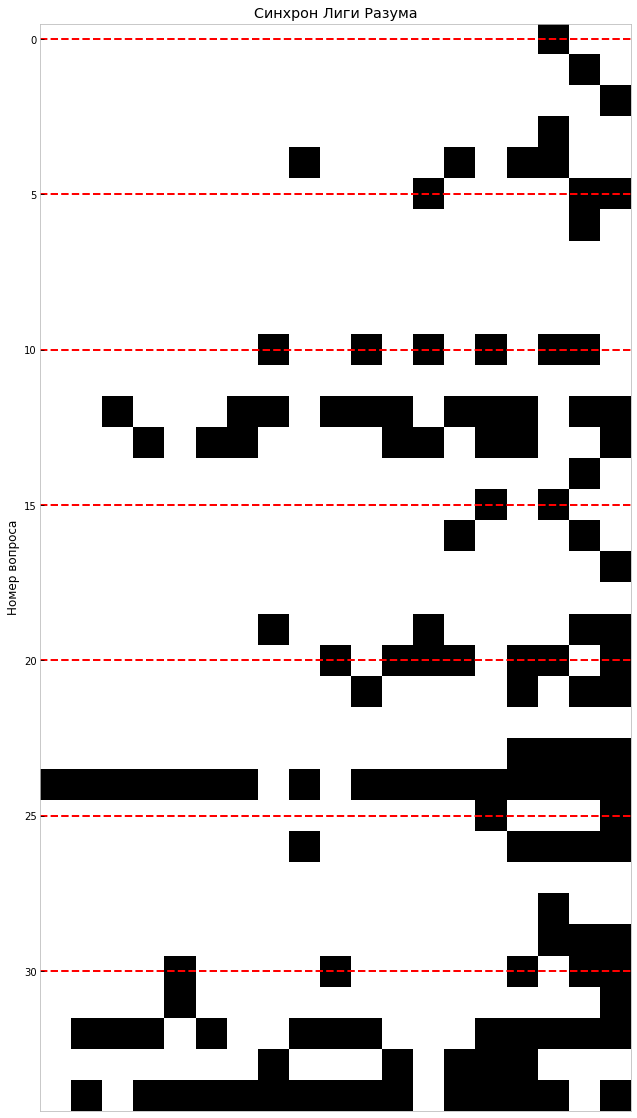

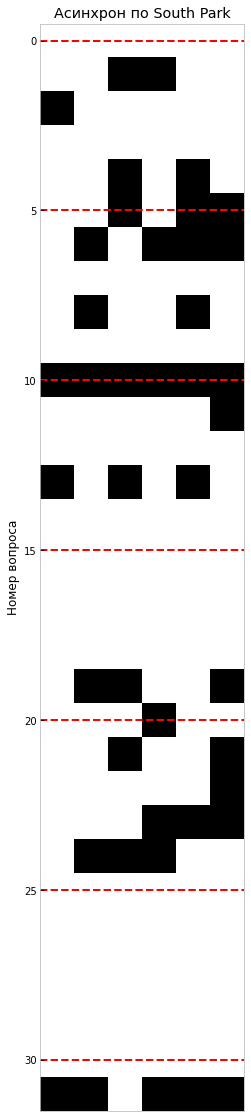

In [195]:
for tour_id in tours_with_questios.iloc[-5:].index:
    plot_tour(team_res, tours, tour_id)

# 6 Бонус топ игроков

In [204]:
players.head()

,tour_id,team_id,player_id,answer_id,is_right_answer
0,4772,45556,6212,0,True
1,4772,45556,6212,1,True
2,4772,45556,6212,2,True
3,4772,45556,6212,3,True
4,4772,45556,6212,4,True


In [205]:
players_total_questions = players.groupby("player_id").agg(total_answers=("answer_id", "count"), total_tours=("tour_id", pd.Series.nunique))

In [206]:
player_ratings = get_player_skills(skils_encoder, weights)

In [207]:
player_skill_quest = players_total_questions.join(player_ratings)
player_skill_quest.sort_values("skill", inplace=True, ascending=False)

In [208]:
top_n = 15

In [209]:
player_skill_quest.head(n=top_n)

,total_answers,total_tours,skill
player_id,,,
27403,2175,55,3.107517
4270,2689,67,2.970896
28751,3770,95,2.918128
27822,3210,79,2.829770
30270,3732,87,2.758515
40411,45,1,2.755654
30152,4845,124,2.745628
38175,36,1,2.685601
20691,1581,37,2.647541


Т. к. нам нужно, чтобы игрок отиграл хотя бы несколько турниров, то возьмём нижнию границу для числа вопросов, равное:

In [210]:
min_answers = player_skill_quest["total_answers"].quantile(0.2)

In [211]:
min_answers

36.0

Т. к. игроки мало играли, то их влияние на командный результат будет незначительным. Скорее всего это игроки, которые попробовали сыграть несколько раз и больше не играли. Данных для оценки их "силы" с точки зрения статистики достаточно мало, поэтому можно убраь их из данных для обучения.

In [212]:
players_with_many_answers = player_skill_quest[player_skill_quest["total_answers"] > min_answers].index

In [213]:
players.shape

(17823516, 5)

In [214]:
filtered_players = players[players["player_id"].isin(players_with_many_answers)]

In [215]:
filtered_players.head()

,tour_id,team_id,player_id,answer_id,is_right_answer
0,4772,45556,6212,0,True
1,4772,45556,6212,1,True
2,4772,45556,6212,2,True
3,4772,45556,6212,3,True
4,4772,45556,6212,4,True


In [216]:
filtered_players.shape

(17185131, 5)

In [217]:
skils_encoder, questione_complex_encoder, features, target = get_features_target(filtered_players, feature_dtype)

In [218]:
regression = linear_model.LogisticRegression(
        penalty="l1", C=1000, solver="liblinear", verbose=2, max_iter=50, fit_intercept=True)
regression.fit(features, target)

[LibLinear]

LogisticRegression(C=1000, max_iter=50, penalty='l1', solver='liblinear',
                   verbose=2)

In [219]:
metrics_history, path_to_checkpoint = train_em(features, target, filtered_players, skils_encoder, test_team_ratings, baseline, regression.coef_, regression.intercept_)

2021-04-08 01:52:38,060 INFO em_algo __init__ Will train logistic regression on cuda
2021-04-08 01:52:48,225 INFO em_algo _build_player_team_round_indices Building mask for zeroing hidden variables
2021-04-08 01:52:48,244 INFO em_algo _build_player_team_round_indices Use 100000 as base value for grouping


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.38it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-08 01:53:41,460 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:53:41,464 INFO em_algo _validate Kendall +0.000863
2021-04-08 01:53:41,467 INFO em_algo _validate Spearman -0.000202
2021-04-08 01:53:41,470 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-08 01:53:41,521 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6096194992807542, 'Spearman': 0.7713992385541419}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.36it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-08 01:53:55,301 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:53:55,303 INFO em_algo _validate Kendall +0.001278
2021-04-08 01:53:55,307 INFO em_algo _validate Spearman +0.000354
2021-04-08 01:53:55,310 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-08 01:53:55,317 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:53:55,319 INFO em_algo _validate Kendall +0.000415
2021-04-08 01:53:55,321 INFO em_algo _validate Spearman +0.000556
2021-04-08 01:53:55,323 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6100345883026457, 'Spearman': 0.7719551711933459}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.37it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-08 01:54:09,263 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:54:09,264 INFO em_algo _validate Kendall +0.001281
2021-04-08 01:54:09,266 INFO em_algo _validate Spearman +0.000357
2021-04-08 01:54:09,270 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-08 01:54:09,284 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:54:09,287 INFO em_algo _validate Kendall +0.000003
2021-04-08 01:54:09,290 INFO em_algo _validate Spearman +0.000003
2021-04-08 01:54:09,295 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6100372407487502, 'Spearman': 0.7719579678109547}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.36it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-08 01:54:23,044 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:54:23,046 INFO em_algo _validate Kendall +0.001282
2021-04-08 01:54:23,048 INFO em_algo _validate Spearman +0.000357
2021-04-08 01:54:23,052 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-08 01:54:23,062 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:54:23,065 INFO em_algo _validate Kendall +0.000001
2021-04-08 01:54:23,068 INFO em_algo _validate Spearman +0.000001
2021-04-08 01:54:23,070 INFO em_algo _validate Corr coefficients: {'Kendall': 0.610038337532986, 'Spearman': 0.771958641589421}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.38it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-08 01:54:36,376 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:54:36,378 INFO em_algo _validate Kendall +0.001251
2021-04-08 01:54:36,379 INFO em_algo _validate Spearman +0.000348
2021-04-08 01:54:36,380 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:54:36,380 INFO em_algo _validate Kendall -0.000031
2021-04-08 01:54:36,381 INFO em_algo _validate Spearman -0.000010
2021-04-08 01:54:36,382 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6100071728287868, 'Spearman': 0.7719490728530999}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.34it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-08 01:54:50,130 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:54:50,131 INFO em_algo _validate Kendall +0.001249
2021-04-08 01:54:50,132 INFO em_algo _validate Spearman +0.000347
2021-04-08 01:54:50,133 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:54:50,135 INFO em_algo _validate Kendall -0.000002
2021-04-08 01:54:50,137 INFO em_algo _validate Spearman -0.000000
2021-04-08 01:54:50,139 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6100053393135348, 'Spearman': 0.7719488707501575}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.37it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-08 01:55:03,740 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:55:03,741 INFO em_algo _validate Kendall +0.001272
2021-04-08 01:55:03,743 INFO em_algo _validate Spearman +0.000355
2021-04-08 01:55:03,744 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:55:03,746 INFO em_algo _validate Kendall +0.000023
2021-04-08 01:55:03,748 INFO em_algo _validate Spearman +0.000007
2021-04-08 01:55:03,749 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6100285670131826, 'Spearman': 0.7719561979703142}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.34it/s, Binary cross entropy=0.466, MAE=0.000212]


2021-04-08 01:55:18,756 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-08 01:55:18,757 INFO em_algo _validate Kendall +0.001270
2021-04-08 01:55:18,758 INFO em_algo _validate Spearman +0.000354
2021-04-08 01:55:18,759 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-08 01:55:18,760 INFO em_algo _validate Kendall -0.000002
2021-04-08 01:55:18,760 INFO em_algo _validate Spearman -0.000001
2021-04-08 01:55:18,762 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6100265959339444, 'Spearman': 0.771955519038137}


M step: 100%|████████████████████████████████████████████████████████████████████████████| 8/8 [01:50<00:00, 13.81s/it]


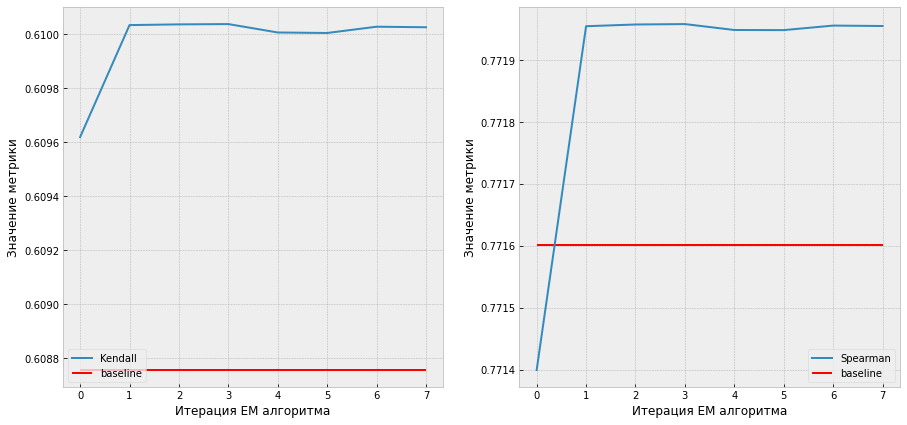

In [220]:
plot_target_metrics(metrics_history)

Результаты по сранению с EM алгоритмом при обучении нв всех игроках не сильно изменились. Один из коэффициентов вырос, а другой стал немного хуже.

In [230]:
weights = torch.load(path_to_checkpoint, map_location="cpu")[state_key][0].numpy()

In [231]:
player_ratings = get_player_skills(skils_encoder, weights)
player_ratings.sort_values("skill", inplace=True, ascending=False)

In [232]:
player_ratings = player_ratings.join(real_data)

Топ игроков по сравнению с реальным рейтингом 2019 года.

In [233]:
player_ratings.iloc[:15]

,skill,Место
27403,3.036342,5.0
4270,2.899510,6.0
28751,2.846513,2.0
27822,2.758185,3.0
30270,2.686891,4.0
40411,2.684561,NaN
30152,2.673887,1.0
20691,2.575957,NaN
18036,2.518183,NaN
22799,2.495644,NaN


Text(0.5, 1.0, 'Распредление "силы игроков"')

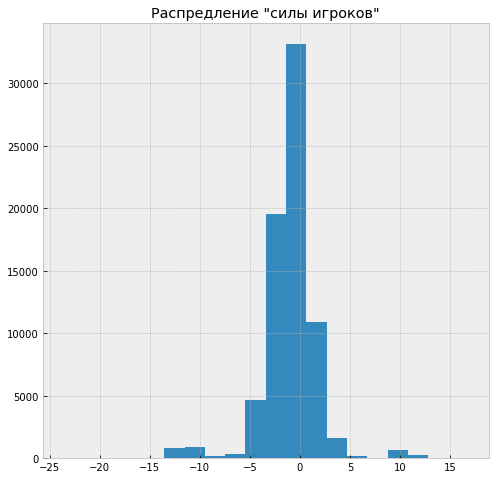

In [239]:
plt.hist(regression.coef_[0], bins=20)
plt.title("Распредление \"силы игроков\"")